# Analisi Sentiment Analysis Amazon Reviews - 3 Classi

Questo notebook analizza i risultati del modello di sentiment analysis a 3 classi (negativo/neutro/positivo) su recensioni Amazon.

## Dataset e Modelli Analizzati

Il dataset contiene predizioni di 3 diversi modelli:
- **VADER**: Rule-based sentiment analyzer
- **TF-IDF + Logistic Regression**: Approccio tradizionale ML
- **Gemini**: Large Language Model di Google

## Indice
1. [Caricamento e Esplorazione dei Dati](#caricamento)
2. [Statistiche Descrittive](#statistiche)
3. [Analisi delle Performance](#performance)
4. [Confronto tra Modelli](#confronto)
5. [Analisi degli Errori](#errori)
6. [Conclusioni](#conclusioni)

## 1. Caricamento e Esplorazione dei Dati {#caricamento}

In [6]:
import pandas as pd

# Carica i risultati dal file CSV
df = pd.read_csv('../results/3class/predictions/all_predictions.csv')

In [7]:
# Importiamo le librerie necessarie per l'analisi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Configurazione per i grafici
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Librerie caricate con successo!")

Librerie caricate con successo!


In [8]:
# Esploriamo il dataset
print("📊 INFORMAZIONI GENERALI SUL DATASET")
print("="*50)
print(f"Numero di campioni: {len(df):,}")
print(f"Numero di colonne: {df.shape[1]}")
print(f"\nColonne disponibili:")
for col in df.columns:
    print(f"  - {col}")

print(f"\nPrime 3 righe del dataset:")
df.head(3)

📊 INFORMAZIONI GENERALI SUL DATASET
Numero di campioni: 5,000
Numero di colonne: 5

Colonne disponibili:
  - text
  - true_label
  - vader_pred
  - tfidf_pred
  - gemini_pred

Prime 3 righe del dataset:


,text,true_label,vader_pred,tfidf_pred,gemini_pred
0,Don’t waste your time!\n\nThese are AWFUL. The...,neg,neg,neg,neg
1,One Star\n\nI bought 4 and NONE of them worked...,neg,pos,neg,neg
2,Totally useless\n\nOn first use it didn't heat...,neg,neg,neg,neg


## 2. Statistiche Descrittive {#statistiche}

In [14]:
# Normalizziamo i dati per un'analisi consistente
print("🔄 NORMALIZZAZIONE DEI DATI")
print("="*40)

# Convertiamo tutto a formato stringa per semplicità
df_clean = df.copy()

# I dati sono già in formato stringa, quindi non serve mapping
df_clean['vader_pred_str'] = df_clean['vader_pred']
df_clean['tfidf_pred_str'] = df_clean['tfidf_pred']

print("Normalizzazione completata:")
print("- VADER: già in formato stringa ('neg', 'neu', 'pos')")
print("- TF-IDF: già in formato stringa ('neg', 'neu', 'pos')")
print("- Gemini: già in formato stringa")
print("- True Labels: già in formato stringa")

# Verifichiamo la distribuzione delle label vere
print("\n📈 DISTRIBUZIONE DELLE LABEL VERE:")
label_counts = df_clean['true_label'].value_counts()
print(label_counts)
print(f"\nPercentuale:")
for label, count in label_counts.items():
    pct = (count / len(df_clean)) * 100
    print(f"  {label}: {pct:.1f}%")

🔄 NORMALIZZAZIONE DEI DATI
Normalizzazione completata:
- VADER: già in formato stringa ('neg', 'neu', 'pos')
- TF-IDF: già in formato stringa ('neg', 'neu', 'pos')
- Gemini: già in formato stringa
- True Labels: già in formato stringa

📈 DISTRIBUZIONE DELLE LABEL VERE:
true_label
neg    2000
pos    2000
neu    1000
Name: count, dtype: int64

Percentuale:
  neg: 40.0%
  pos: 40.0%
  neu: 20.0%


In [15]:
# Let's check for any missing values or data issues
print("\n🔍 CONTROLLO DATI MANCANTI:")
print("="*40)

print("Valori mancanti per colonna:")
for col in ['true_label', 'vader_pred_str', 'tfidf_pred_str', 'gemini_pred']:
    missing = df_clean[col].isnull().sum()
    print(f"  {col}: {missing}")

print("\nValori unici per colonna:")
for col in ['true_label', 'vader_pred_str', 'tfidf_pred_str', 'gemini_pred']:
    unique_vals = df_clean[col].unique()
    print(f"  {col}: {unique_vals}")

print("\nConteggio valori per colonna:")
for col in ['true_label', 'vader_pred_str', 'tfidf_pred_str', 'gemini_pred']:
    print(f"\n{col}:")
    counts = df_clean[col].value_counts()
    print(counts)


🔍 CONTROLLO DATI MANCANTI:
Valori mancanti per colonna:
  true_label: 0
  vader_pred_str: 0
  tfidf_pred_str: 0
  gemini_pred: 0

Valori unici per colonna:
  true_label: ['neg' 'neu' 'pos']
  vader_pred_str: ['neg' 'pos' 'neu']
  tfidf_pred_str: ['neg' 'neu' 'pos']
  gemini_pred: ['neg' 'neu' 'pos']

Conteggio valori per colonna:

true_label:
true_label
neg    2000
pos    2000
neu    1000
Name: count, dtype: int64

vader_pred_str:
vader_pred_str
pos    3077
neg    1456
neu     467
Name: count, dtype: int64

tfidf_pred_str:
tfidf_pred_str
pos    1911
neg    1897
neu    1192
Name: count, dtype: int64

gemini_pred:
gemini_pred
neg    2446
pos    1489
neu    1065
Name: count, dtype: int64


In [13]:
# Let's check the original VADER and TF-IDF prediction values
print("\n🔍 CONTROLLO VALORI ORIGINALI:")
print("="*40)

print("Valori originali VADER:")
print(f"  Tipo: {df['vader_pred'].dtype}")
print(f"  Valori unici: {df['vader_pred'].unique()}")
print(f"  Distribuzione:")
print(df['vader_pred'].value_counts())

print("\nValori originali TF-IDF:")
print(f"  Tipo: {df['tfidf_pred'].dtype}")
print(f"  Valori unici: {df['tfidf_pred'].unique()}")
print(f"  Distribuzione:")
print(df['tfidf_pred'].value_counts())

print("\nPrime 5 righe del dataset originale:")
print(df[['true_label', 'vader_pred', 'tfidf_pred', 'gemini_pred']].head())


🔍 CONTROLLO VALORI ORIGINALI:
Valori originali VADER:
  Tipo: object
  Valori unici: ['neg' 'pos' 'neu']
  Distribuzione:
vader_pred
pos    3077
neg    1456
neu     467
Name: count, dtype: int64

Valori originali TF-IDF:
  Tipo: object
  Valori unici: ['neg' 'neu' 'pos']
  Distribuzione:
tfidf_pred
pos    1911
neg    1897
neu    1192
Name: count, dtype: int64

Prime 5 righe del dataset originale:
  true_label vader_pred tfidf_pred gemini_pred
0        neg        neg        neg         neg
1        neg        pos        neg         neg
2        neg        neg        neg         neg
3        neg        pos        neg         neg
4        neg        pos        neg         neg


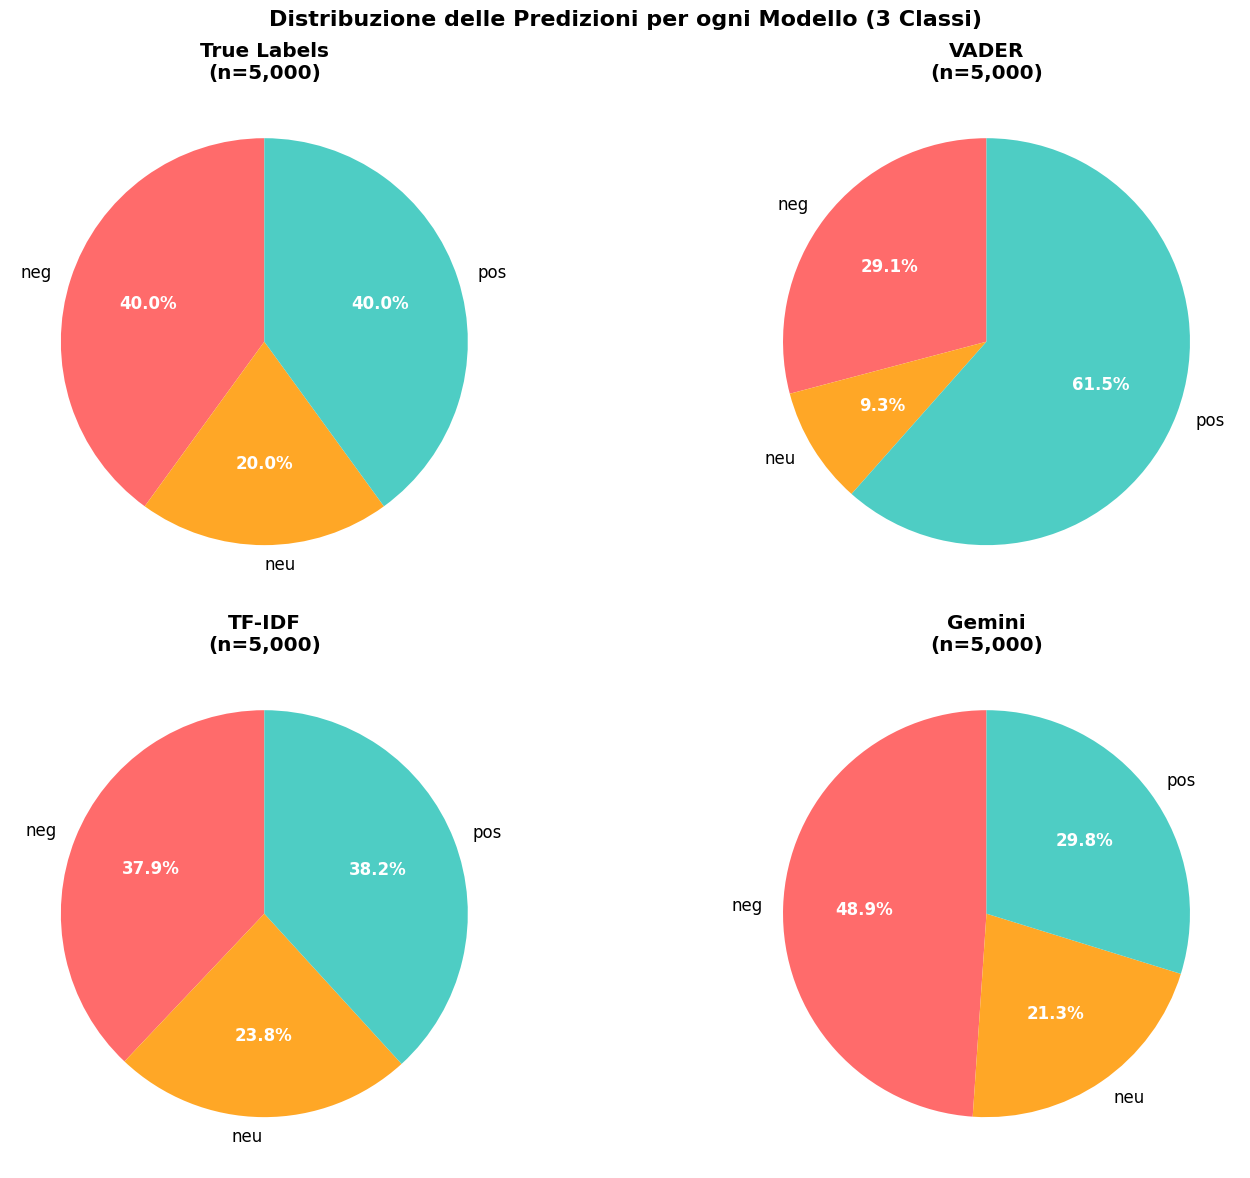


📊 RIEPILOGO DELLE DISTRIBUZIONI:

True Labels:
  neg: 2,000 (40.0%)
  neu: 1,000 (20.0%)
  pos: 2,000 (40.0%)

VADER:
  neg: 1,456 (29.1%)
  neu: 467 (9.3%)
  pos: 3,077 (61.5%)

TF-IDF:
  neg: 1,897 (37.9%)
  neu: 1,192 (23.8%)
  pos: 1,911 (38.2%)

Gemini:
  neg: 2,446 (48.9%)
  neu: 1,065 (21.3%)
  pos: 1,489 (29.8%)


In [16]:
# Visualizziamo la distribuzione delle predizioni per ogni modello
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribuzione delle Predizioni per ogni Modello (3 Classi)', fontsize=16, fontweight='bold')

models = [
    ('true_label', 'True Labels', axes[0, 0]),
    ('vader_pred_str', 'VADER', axes[0, 1]),
    ('tfidf_pred_str', 'TF-IDF', axes[1, 0]),
    ('gemini_pred', 'Gemini', axes[1, 1])
]

# Colori per le 3 classi
colors = ['#FF6B6B', '#FFA726', '#4ECDC4']

for col, title, ax in models:
    counts = df_clean[col].value_counts()
    # Ordiniamo le categorie: neg, neu, pos
    ordered_labels = ['neg', 'neu', 'pos']
    ordered_counts = [counts.get(label, 0) for label in ordered_labels]
    
    wedges, texts, autotexts = ax.pie(ordered_counts, labels=ordered_labels, autopct='%1.1f%%', 
                                     colors=colors, startangle=90)
    ax.set_title(f'{title}\n(n={len(df_clean):,})', fontweight='bold')
    
    # Miglioriamo la leggibilità del testo
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Statistiche testuali
print("\n📊 RIEPILOGO DELLE DISTRIBUZIONI:")
print("="*50)
for col, title, _ in models:
    counts = df_clean[col].value_counts()
    print(f"\n{title}:")
    # Ordiniamo per neg, neu, pos
    for label in ['neg', 'neu', 'pos']:
        if label in counts:
            count = counts[label]
            pct = (count / len(df_clean)) * 100
            print(f"  {label}: {count:,} ({pct:.1f}%)")
        else:
            print(f"  {label}: 0 (0.0%)")

### Osservazioni iniziali:
- La distribuzione delle **true labels** mostra il bilanciamento del dataset tra le 3 classi
- **VADER** potrebbe avere bias specifici per la classificazione a 3 classi
- **TF-IDF** dovrebbe mantenere una buona rappresentazione della distribuzione originale
- **Gemini** mostra le predizioni del modello LLM per il sentiment a 3 classi

## 3. Analisi delle Performance {#performance}

In [17]:
# Calcoliamo le metriche di performance per ogni modello
def calculate_metrics(y_true, y_pred, model_name):
    """Calcola le metriche di performance per un modello"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Calcoliamo le metriche per tutti i modelli
y_true = df_clean['true_label']

models_metrics = [
    calculate_metrics(y_true, df_clean['vader_pred_str'], 'VADER'),
    calculate_metrics(y_true, df_clean['tfidf_pred_str'], 'TF-IDF'),
    calculate_metrics(y_true, df_clean['gemini_pred'], 'Gemini')
]

# Creiamo un DataFrame con i risultati
metrics_df = pd.DataFrame(models_metrics)
metrics_df = metrics_df.round(4)

print("🎯 METRICHE DI PERFORMANCE (3 CLASSI)")
print("="*60)
print(metrics_df.to_string(index=False))

# Identifichiamo il modello migliore per ogni metrica
print("\n🏆 MODELLI MIGLIORI PER METRICA:")
print("="*40)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_idx = metrics_df[metric].idxmax()
    best_model = metrics_df.iloc[best_idx]['Model']
    best_value = metrics_df.iloc[best_idx][metric]
    print(f"{metric}: {best_model} ({best_value:.4f})")

🎯 METRICHE DI PERFORMANCE (3 CLASSI)
 Model  Accuracy  Precision  Recall  F1-Score
 VADER    0.5892     0.5643  0.5892    0.5533
TF-IDF    0.7564     0.7708  0.7564    0.7624
Gemini    0.7344     0.7607  0.7344    0.7370

🏆 MODELLI MIGLIORI PER METRICA:
Accuracy: TF-IDF (0.7564)
Precision: TF-IDF (0.7708)
Recall: TF-IDF (0.7564)
F1-Score: TF-IDF (0.7624)


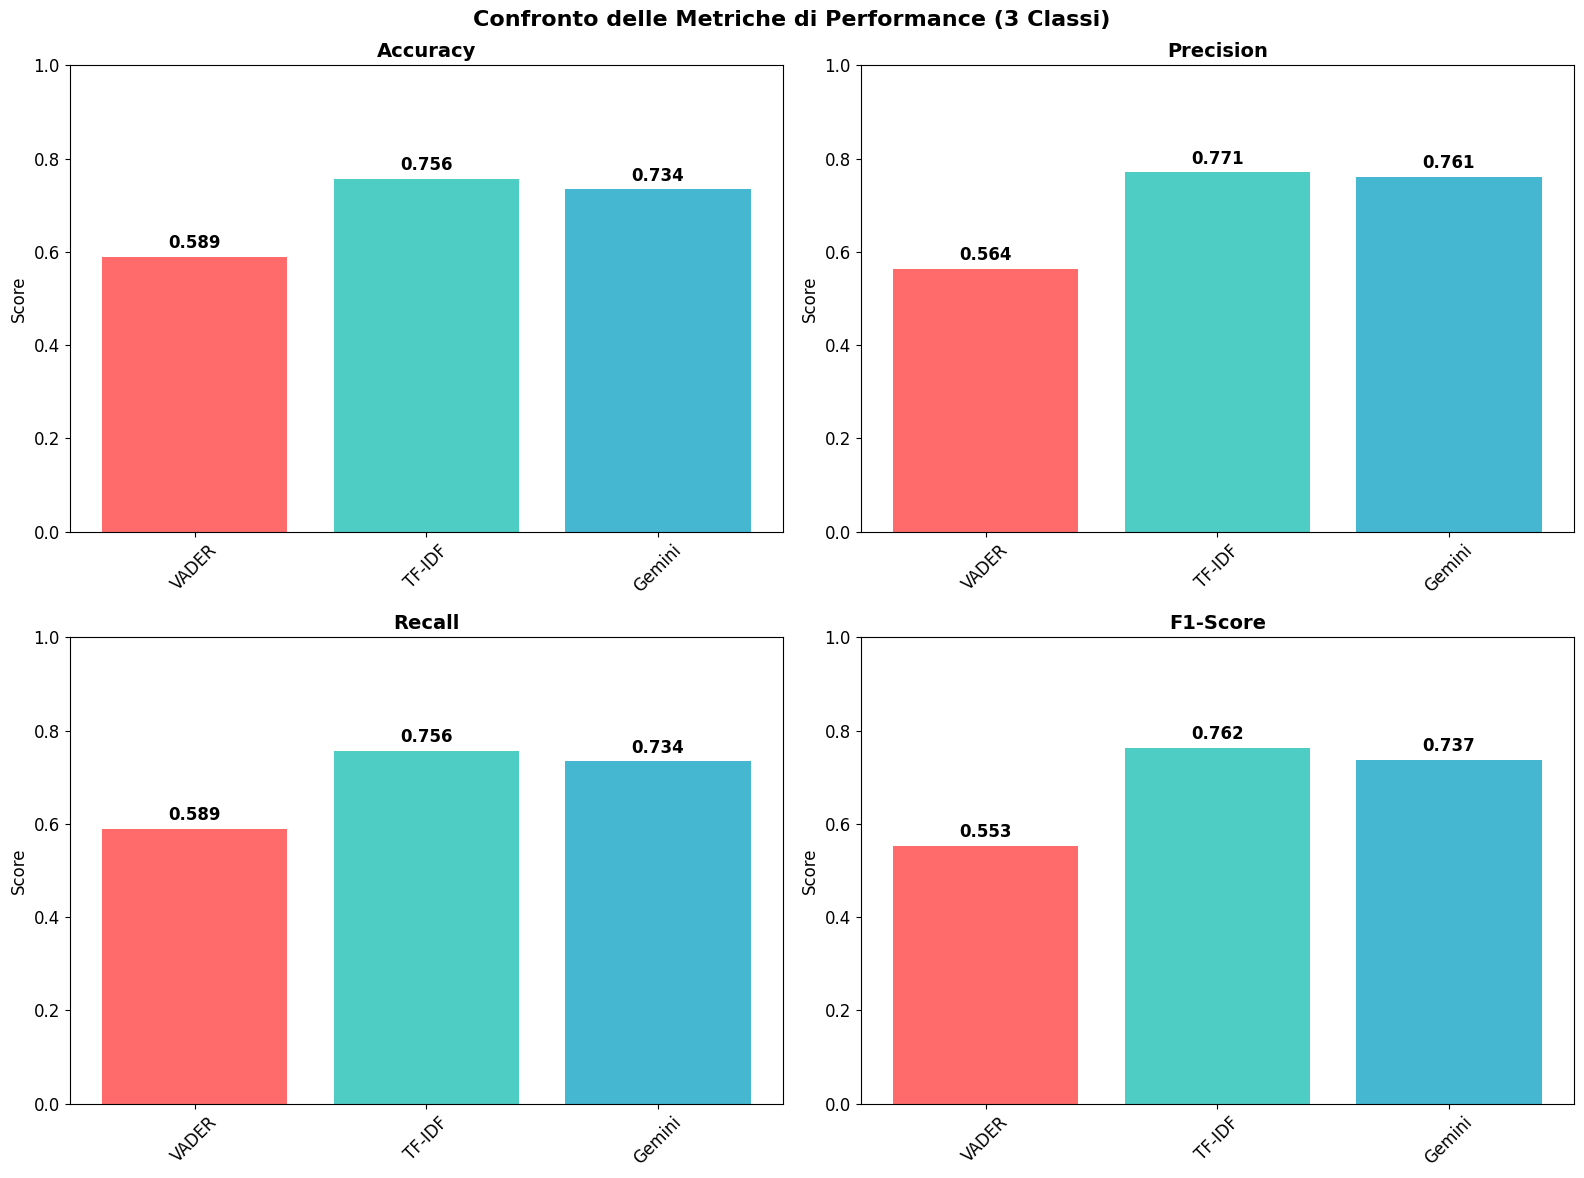

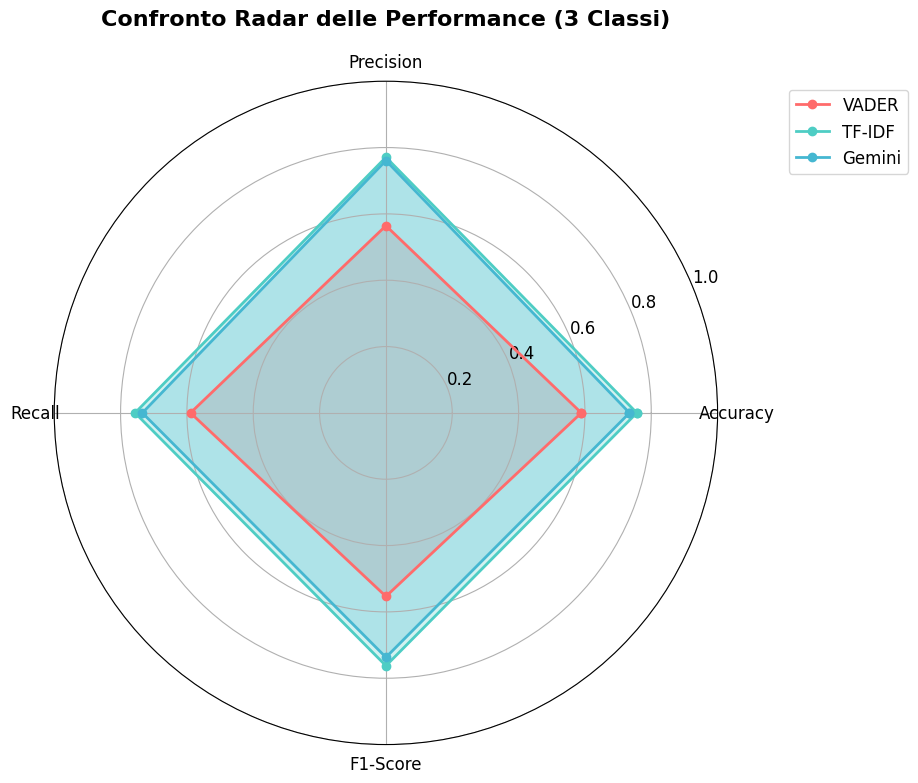

In [18]:
# Visualizziamo le metriche in un grafico a barre
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Confronto delle Metriche di Performance (3 Classi)', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(metrics_df['Model'], metrics_df[metric], color=colors)
    ax.set_title(f'{metric}', fontweight='bold', fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    
    # Aggiungiamo i valori sopra le barre
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Ruotiamo le etichette dell'asse x
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Grafico radar per confronto complessivo
from math import pi

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
N = len(categories)

# Calcola gli angoli per ogni asse
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot per ogni modello
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
models = ['VADER', 'TF-IDF', 'Gemini']

for i, model in enumerate(models):
    values = metrics_df[metrics_df['Model'] == model][categories].iloc[0].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Confronto Radar delle Performance (3 Classi)', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()

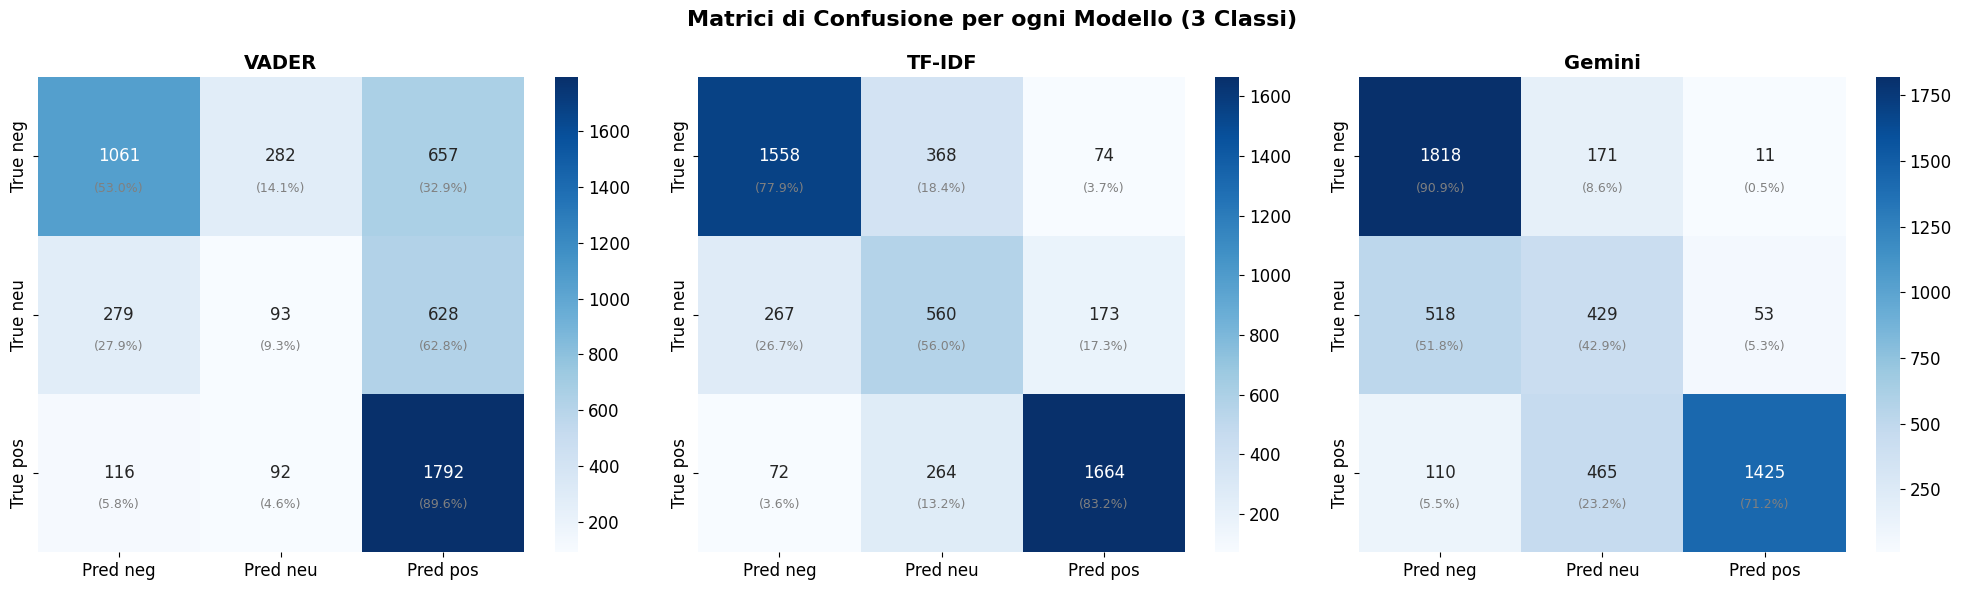


📋 REPORT DI CLASSIFICAZIONE DETTAGLIATI (3 CLASSI)

🔍 VADER:
------------------------------
              precision    recall  f1-score   support

         neg       0.73      0.53      0.61      2000
         neu       0.20      0.09      0.13      1000
         pos       0.58      0.90      0.71      2000

    accuracy                           0.59      5000
   macro avg       0.50      0.51      0.48      5000
weighted avg       0.56      0.59      0.55      5000


🔍 TF-IDF:
------------------------------
              precision    recall  f1-score   support

         neg       0.82      0.78      0.80      2000
         neu       0.47      0.56      0.51      1000
         pos       0.87      0.83      0.85      2000

    accuracy                           0.76      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.77      0.76      0.76      5000


🔍 Gemini:
------------------------------
              precision    recall  f1-score   support

      

In [19]:
# Matrice di confusione per ogni modello
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Matrici di Confusione per ogni Modello (3 Classi)', fontsize=16, fontweight='bold')

models_data = [
    ('VADER', df_clean['vader_pred_str']),
    ('TF-IDF', df_clean['tfidf_pred_str']),
    ('Gemini', df_clean['gemini_pred'])
]

class_labels = ['neg', 'neu', 'pos']

for i, (model_name, y_pred) in enumerate(models_data):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    
    # Calcoliamo le percentuali
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Creiamo la heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=[f'Pred {label}' for label in class_labels],
                yticklabels=[f'True {label}' for label in class_labels])
    
    axes[i].set_title(f'{model_name}', fontweight='bold', fontsize=14)
    
    # Aggiungiamo le percentuali come testo aggiuntivo
    for j in range(3):
        for k in range(3):
            axes[i].text(k+0.5, j+0.7, f'({cm_percent[j,k]:.1f}%)', 
                        ha='center', va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

# Stampiamo i report di classificazione dettagliati
print("\n📋 REPORT DI CLASSIFICAZIONE DETTAGLIATI (3 CLASSI)")
print("="*80)

for model_name, y_pred in models_data:
    print(f"\n🔍 {model_name}:")
    print("-" * 30)
    print(classification_report(y_true, y_pred))

## 4. Confronto tra Modelli {#confronto}

In [20]:
# Analizziamo i casi di accordo e disaccordo tra i modelli
print("🤝 ANALISI DEGLI ACCORDI TRA MODELLI (3 CLASSI)")
print("="*50)

# Creiamo una matrice di accordo
agreement_data = []

# Confronti a coppie
pairs = [
    ('VADER', 'vader_pred_str', 'TF-IDF', 'tfidf_pred_str'),
    ('VADER', 'vader_pred_str', 'Gemini', 'gemini_pred'),
    ('TF-IDF', 'tfidf_pred_str', 'Gemini', 'gemini_pred')
]

for model1_name, model1_col, model2_name, model2_col in pairs:
    agreement = (df_clean[model1_col] == df_clean[model2_col]).sum()
    agreement_pct = (agreement / len(df_clean)) * 100
    
    agreement_data.append({
        'Model 1': model1_name,
        'Model 2': model2_name,
        'Agreement': agreement,
        'Agreement %': agreement_pct
    })
    
    print(f"{model1_name} vs {model2_name}: {agreement:,} ({agreement_pct:.1f}%)")

# Accordo tra tutti e 3 i modelli
all_agree = ((df_clean['vader_pred_str'] == df_clean['tfidf_pred_str']) & 
             (df_clean['tfidf_pred_str'] == df_clean['gemini_pred'])).sum()
all_agree_pct = (all_agree / len(df_clean)) * 100

print(f"\nAccordo tra tutti e 3 i modelli: {all_agree:,} ({all_agree_pct:.1f}%)")

# Analizziamo quando tutti e 3 sono corretti
all_correct = ((df_clean['vader_pred_str'] == df_clean['true_label']) & 
               (df_clean['tfidf_pred_str'] == df_clean['true_label']) & 
               (df_clean['gemini_pred'] == df_clean['true_label'])).sum()
all_correct_pct = (all_correct / len(df_clean)) * 100

print(f"Tutti e 3 corretti: {all_correct:,} ({all_correct_pct:.1f}%)")

# Analizziamo quando tutti e 3 sono sbagliati
all_wrong = ((df_clean['vader_pred_str'] != df_clean['true_label']) & 
             (df_clean['tfidf_pred_str'] != df_clean['true_label']) & 
             (df_clean['gemini_pred'] != df_clean['true_label'])).sum()
all_wrong_pct = (all_wrong / len(df_clean)) * 100

print(f"Tutti e 3 sbagliati: {all_wrong:,} ({all_wrong_pct:.1f}%)")

🤝 ANALISI DEGLI ACCORDI TRA MODELLI (3 CLASSI)
VADER vs TF-IDF: 2,956 (59.1%)
VADER vs Gemini: 2,741 (54.8%)
TF-IDF vs Gemini: 3,605 (72.1%)

Accordo tra tutti e 3 i modelli: 2,387 (47.7%)
Tutti e 3 corretti: 2,196 (43.9%)
Tutti e 3 sbagliati: 419 (8.4%)


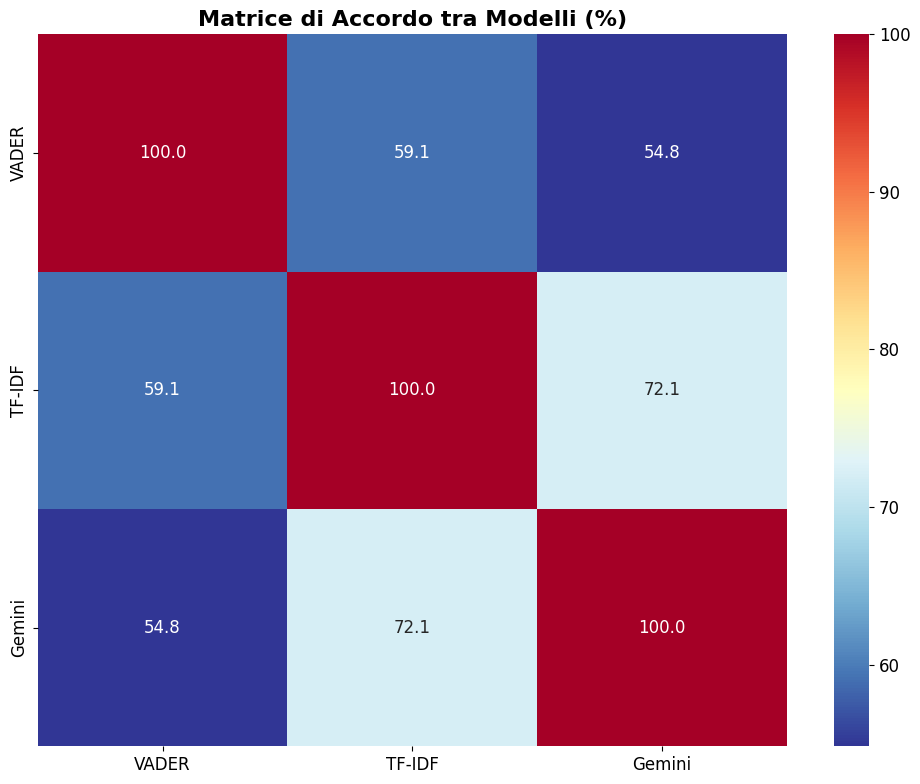

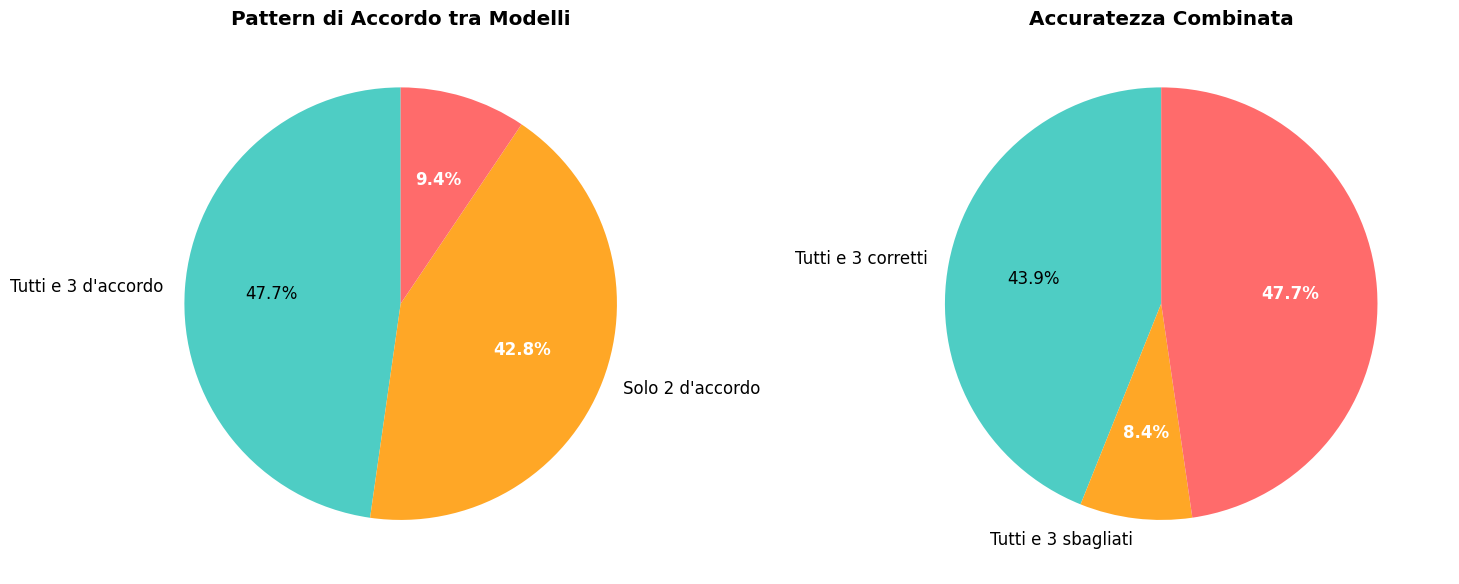

In [21]:
# Visualizziamo la matrice di accordo
agreement_matrix = np.zeros((3, 3))
models = ['VADER', 'TF-IDF', 'Gemini']
model_cols = ['vader_pred_str', 'tfidf_pred_str', 'gemini_pred']

for i in range(3):
    for j in range(3):
        if i == j:
            agreement_matrix[i, j] = 100  # Accordo perfetto con se stesso
        else:
            agreement = (df_clean[model_cols[i]] == df_clean[model_cols[j]]).sum()
            agreement_matrix[i, j] = (agreement / len(df_clean)) * 100

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, fmt='.1f', cmap='RdYlBu_r', 
            xticklabels=models, yticklabels=models, ax=ax)
ax.set_title('Matrice di Accordo tra Modelli (%)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Grafico a torta per visualizzare i pattern di accordo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accordi
labels = ['Tutti e 3 d\'accordo', 'Solo 2 d\'accordo', 'Tutti in disaccordo']
sizes = [all_agree_pct, 100 - all_agree_pct - (100 - all_agree_pct), 100 - all_agree_pct]

# Ricalcoliamo correttamente
only_two_agree = len(df_clean) - all_agree - ((df_clean['vader_pred_str'] != df_clean['tfidf_pred_str']) & 
                                              (df_clean['tfidf_pred_str'] != df_clean['gemini_pred']) & 
                                              (df_clean['vader_pred_str'] != df_clean['gemini_pred'])).sum()

all_disagree = ((df_clean['vader_pred_str'] != df_clean['tfidf_pred_str']) & 
                (df_clean['tfidf_pred_str'] != df_clean['gemini_pred']) & 
                (df_clean['vader_pred_str'] != df_clean['gemini_pred'])).sum()

sizes = [all_agree, only_two_agree, all_disagree]
sizes_pct = [x/len(df_clean)*100 for x in sizes]

colors = ['#4ECDC4', '#FFA726', '#FF6B6B']
wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Pattern di Accordo tra Modelli', fontweight='bold')

# Accuratezza
correct_labels = ['Tutti e 3 corretti', 'Tutti e 3 sbagliati', 'Misto']
correct_sizes = [all_correct, all_wrong, len(df_clean) - all_correct - all_wrong]
correct_sizes_pct = [x/len(df_clean)*100 for x in correct_sizes]

wedges, texts, autotexts = ax2.pie(correct_sizes, labels=correct_labels, autopct='%1.1f%%', 
                                  colors=colors, startangle=90)
ax2.set_title('Accuratezza Combinata', fontweight='bold')

for autotexts_list in [ax1.texts[3:], ax2.texts[3:]]:
    for autotext in autotexts_list:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

## 5. Analisi degli Errori {#errori}

In [22]:
# Analizziamo gli errori di ogni modello
print("🔍 ANALISI DETTAGLIATA DEGLI ERRORI (3 CLASSI)")
print("="*60)

models_error_analysis = []

for model_name, pred_col in [('VADER', 'vader_pred_str'), ('TF-IDF', 'tfidf_pred_str'), ('Gemini', 'gemini_pred')]:
    errors = df_clean[df_clean[pred_col] != df_clean['true_label']]
    error_count = len(errors)
    error_pct = (error_count / len(df_clean)) * 100
    
    print(f"\n📊 {model_name}:")
    print(f"  Errori totali: {error_count:,} ({error_pct:.1f}%)")
    
    # Analisi per classe
    error_summary = {}
    for true_class in ['neg', 'neu', 'pos']:
        class_errors = errors[errors['true_label'] == true_class]
        if len(class_errors) > 0:
            print(f"  Errori su '{true_class}': {len(class_errors):,}")
            
            # Vediamo cosa predice per questa classe
            pred_distribution = class_errors[pred_col].value_counts()
            for pred_class, count in pred_distribution.items():
                pct = (count / len(class_errors)) * 100
                print(f"    → predice '{pred_class}': {count} ({pct:.1f}%)")
                
                error_summary[f"{true_class}_to_{pred_class}"] = {
                    'count': count,
                    'percentage': pct
                }
    
    models_error_analysis.append({
        'model': model_name,
        'total_errors': error_count,
        'error_rate': error_pct,
        'error_patterns': error_summary
    })

🔍 ANALISI DETTAGLIATA DEGLI ERRORI (3 CLASSI)

📊 VADER:
  Errori totali: 2,054 (41.1%)
  Errori su 'neg': 939
    → predice 'pos': 657 (70.0%)
    → predice 'neu': 282 (30.0%)
  Errori su 'neu': 907
    → predice 'pos': 628 (69.2%)
    → predice 'neg': 279 (30.8%)
  Errori su 'pos': 208
    → predice 'neg': 116 (55.8%)
    → predice 'neu': 92 (44.2%)

📊 TF-IDF:
  Errori totali: 1,218 (24.4%)
  Errori su 'neg': 442
    → predice 'neu': 368 (83.3%)
    → predice 'pos': 74 (16.7%)
  Errori su 'neu': 440
    → predice 'neg': 267 (60.7%)
    → predice 'pos': 173 (39.3%)
  Errori su 'pos': 336
    → predice 'neu': 264 (78.6%)
    → predice 'neg': 72 (21.4%)

📊 Gemini:
  Errori totali: 1,328 (26.6%)
  Errori su 'neg': 182
    → predice 'neu': 171 (94.0%)
    → predice 'pos': 11 (6.0%)
  Errori su 'neu': 571
    → predice 'neg': 518 (90.7%)
    → predice 'pos': 53 (9.3%)
  Errori su 'pos': 575
    → predice 'neu': 465 (80.9%)
    → predice 'neg': 110 (19.1%)


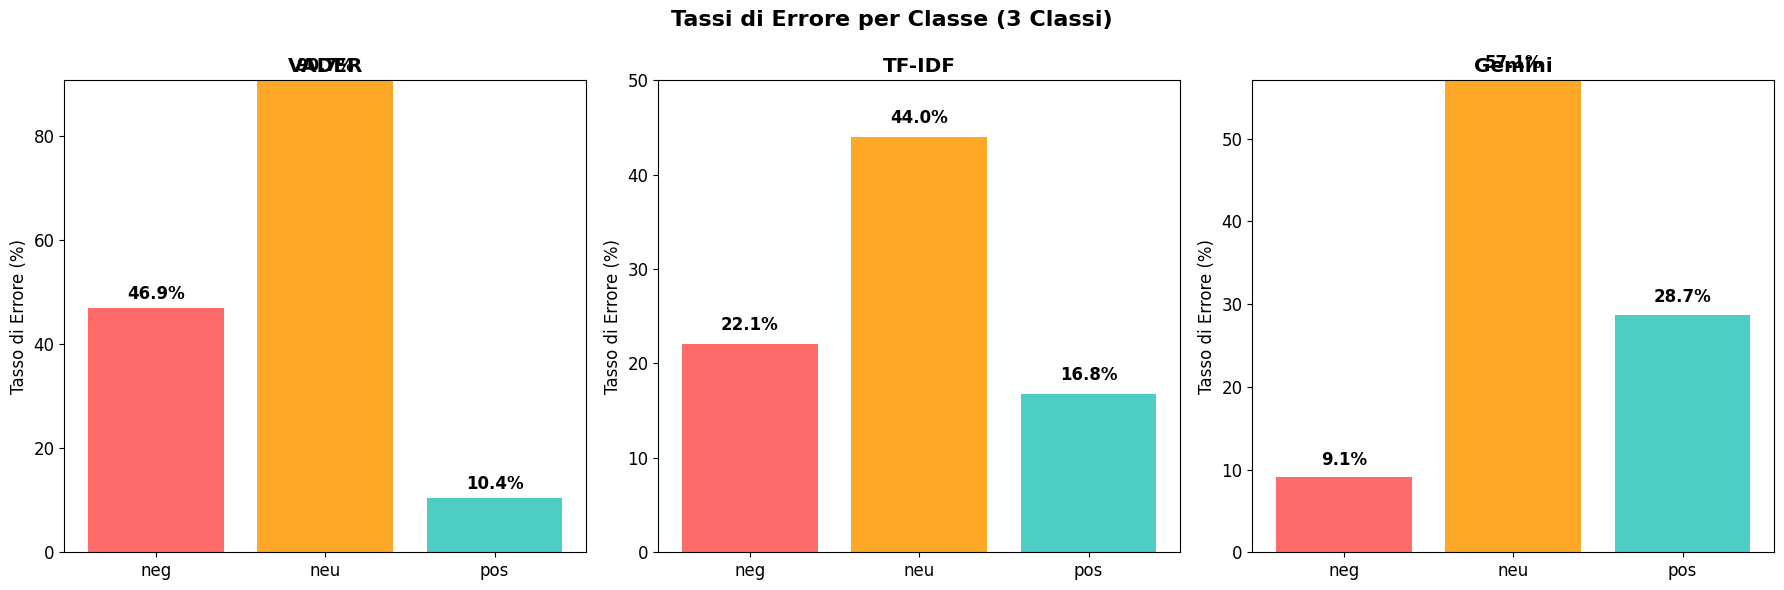


🎯 PATTERN DI ERRORE PIÙ COMUNI:

Casi in cui tutti e 3 modelli sbagliano: 419
Distribuzione per classe vera:
  neu: 259 (61.8%)
  neg: 85 (20.3%)
  pos: 75 (17.9%)

Esempi di testi più problematici:

• True: neg | VADER: neu | TF-IDF: neu | Gemini: neu
  Text: ... with my laundry for a while now and I like it, but I had to return it because ...

I've been usi...

• True: neg | VADER: pos | TF-IDF: pos | Gemini: pos
  Text: One Star

Added so much to the projects! Works well....

• True: neg | VADER: neu | TF-IDF: pos | Gemini: neu
  Text: yhat it works

have not used it yet...


In [23]:
# Visualizziamo i tassi di errore per classe
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Tassi di Errore per Classe (3 Classi)', fontsize=16, fontweight='bold')

class_labels = ['neg', 'neu', 'pos']
colors = ['#FF6B6B', '#FFA726', '#4ECDC4']

for i, (model_name, pred_col) in enumerate([('VADER', 'vader_pred_str'), ('TF-IDF', 'tfidf_pred_str'), ('Gemini', 'gemini_pred')]):
    error_rates = []
    
    for class_label in class_labels:
        class_data = df_clean[df_clean['true_label'] == class_label]
        class_errors = class_data[class_data[pred_col] != class_data['true_label']]
        error_rate = (len(class_errors) / len(class_data)) * 100 if len(class_data) > 0 else 0
        error_rates.append(error_rate)
    
    bars = axes[i].bar(class_labels, error_rates, color=colors)
    axes[i].set_title(f'{model_name}', fontweight='bold')
    axes[i].set_ylabel('Tasso di Errore (%)')
    axes[i].set_ylim(0, max(max(error_rates), 50))
    
    # Aggiungiamo i valori sopra le barre
    for bar, rate in zip(bars, error_rates):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Analizziamo i pattern di errore più comuni
print("\n🎯 PATTERN DI ERRORE PIÙ COMUNI:")
print("="*50)

# Tutti i casi in cui tutti e 3 sbagliano
all_wrong_examples = df_clean[(df_clean['vader_pred_str'] != df_clean['true_label']) & 
                              (df_clean['tfidf_pred_str'] != df_clean['true_label']) & 
                              (df_clean['gemini_pred'] != df_clean['true_label'])]

print(f"\nCasi in cui tutti e 3 modelli sbagliano: {len(all_wrong_examples):,}")

if len(all_wrong_examples) > 0:
    print("Distribuzione per classe vera:")
    error_by_class = all_wrong_examples['true_label'].value_counts()
    for class_label, count in error_by_class.items():
        pct = (count / len(all_wrong_examples)) * 100
        print(f"  {class_label}: {count} ({pct:.1f}%)")
    
    print("\nEsempi di testi più problematici:")
    sample = all_wrong_examples.head(3)
    for idx, row in sample.iterrows():
        print(f"\n• True: {row['true_label']} | VADER: {row['vader_pred_str']} | TF-IDF: {row['tfidf_pred_str']} | Gemini: {row['gemini_pred']}")
        print(f"  Text: {row['text'][:100]}...")

In [24]:
# Confronto degli errori unici di ogni modello
print("🎭 ERRORI UNICI DI OGNI MODELLO:")
print("="*40)

# VADER errori unici (dove solo VADER sbaglia)
vader_only_errors = df_clean[(df_clean['vader_pred_str'] != df_clean['true_label']) & 
                             (df_clean['tfidf_pred_str'] == df_clean['true_label']) & 
                             (df_clean['gemini_pred'] == df_clean['true_label'])]

print(f"\nVADER errori unici: {len(vader_only_errors):,}")
if len(vader_only_errors) > 0:
    pattern_counts = vader_only_errors.apply(lambda row: f"{row['true_label']}→{row['vader_pred_str']}", axis=1).value_counts()
    for pattern, count in pattern_counts.head(3).items():
        print(f"  {pattern}: {count}")

# TF-IDF errori unici
tfidf_only_errors = df_clean[(df_clean['tfidf_pred_str'] != df_clean['true_label']) & 
                             (df_clean['vader_pred_str'] == df_clean['true_label']) & 
                             (df_clean['gemini_pred'] == df_clean['true_label'])]

print(f"\nTF-IDF errori unici: {len(tfidf_only_errors):,}")
if len(tfidf_only_errors) > 0:
    pattern_counts = tfidf_only_errors.apply(lambda row: f"{row['true_label']}→{row['tfidf_pred_str']}", axis=1).value_counts()
    for pattern, count in pattern_counts.head(3).items():
        print(f"  {pattern}: {count}")

# Gemini errori unici
gemini_only_errors = df_clean[(df_clean['gemini_pred'] != df_clean['true_label']) & 
                              (df_clean['vader_pred_str'] == df_clean['true_label']) & 
                              (df_clean['tfidf_pred_str'] == df_clean['true_label'])]

print(f"\nGemini errori unici: {len(gemini_only_errors):,}")
if len(gemini_only_errors) > 0:
    pattern_counts = gemini_only_errors.apply(lambda row: f"{row['true_label']}→{row['gemini_pred']}", axis=1).value_counts()
    for pattern, count in pattern_counts.head(3).items():
        print(f"  {pattern}: {count}")

🎭 ERRORI UNICI DI OGNI MODELLO:

VADER errori unici: 902
  neg→pos: 365
  neg→neu: 214
  neu→pos: 202

TF-IDF errori unici: 191
  neg→neu: 102
  pos→neu: 54
  neg→pos: 14

Gemini errori unici: 334
  pos→neu: 260
  neu→neg: 36
  neg→neu: 19


## 6. Conclusioni {#conclusioni}

## 6. Confronto Dettagliato con Esempi {#confronto-esempi}

Analizziamo esempi concreti per capire meglio le differenze tra i modelli e i loro punti di forza/debolezza.

In [ ]:
# Funzione per creare esempi di confronto tra modelli
def show_model_comparison_examples(df, title, condition_func, max_examples=10):
    """
    Mostra esempi di confronto tra modelli basati su una condizione specifica
    """
    examples = df[condition_func(df)]
    
    print(f"\n{'='*80}")
    print(f"🔍 {title.upper()}")
    print(f"{'='*80}")
    print(f"Trovati {len(examples)} esempi")
    
    if len(examples) == 0:
        print("Nessun esempio trovato per questa categoria.")
        return
    
    # Mostra fino a max_examples esempi
    sample = examples.head(max_examples)
    
    for i, (idx, row) in enumerate(sample.iterrows(), 1):
        print(f"\n📝 ESEMPIO {i}:")
        print(f"   Testo: \"{row['text'][:150]}{'...' if len(row['text']) > 150 else ''}\"")
        print(f"   ✅ Vero:   {row['true_label']}")
        print(f"   🤖 VADER:  {row['vader_pred_str']}")
        print(f"   📊 TF-IDF: {row['tfidf_pred_str']}")
        print(f"   🧠 Gemini: {row['gemini_pred']}")
        
        # Evidenziamo quale modello ha azzeccato
        correct_models = []
        if row['vader_pred_str'] == row['true_label']:
            correct_models.append('VADER')
        if row['tfidf_pred_str'] == row['true_label']:
            correct_models.append('TF-IDF')
        if row['gemini_pred'] == row['true_label']:
            correct_models.append('Gemini')
            
        if correct_models:
            print(f"   ✅ Corretti: {', '.join(correct_models)}")
        else:
            print(f"   ❌ Tutti sbagliati")
    
    return examples

print("🎯 ANALISI COMPARATIVA CON ESEMPI CONCRETI")
print("="*60)

In [25]:
# Creiamo un ranking finale dei modelli
print("🏆 RANKING FINALE DEI MODELLI (3 CLASSI)")
print("="*50)

# Creiamo un punteggio combinato basato su multiple metriche
final_ranking = metrics_df.copy()
final_ranking['Combined_Score'] = (final_ranking['Accuracy'] * 0.4 + 
                                   final_ranking['Precision'] * 0.2 + 
                                   final_ranking['Recall'] * 0.2 + 
                                   final_ranking['F1-Score'] * 0.2)

final_ranking = final_ranking.sort_values('Combined_Score', ascending=False)

print("Ranking basato su punteggio combinato:")
print("(40% Accuracy + 20% Precision + 20% Recall + 20% F1-Score)")
print()

for i, (_, row) in enumerate(final_ranking.iterrows(), 1):
    print(f"{i}. {row['Model']}: {row['Combined_Score']:.4f}")
    print(f"   Accuracy: {row['Accuracy']:.4f} | Precision: {row['Precision']:.4f} | Recall: {row['Recall']:.4f} | F1: {row['F1-Score']:.4f}")
    print()

# Summary finale
print("📋 SUMMARY ESECUTIVO:")
print("="*30)
print(f"• Dataset: {len(df):,} recensioni Amazon analizzate")
print(f"• Modelli confrontati: 3 (VADER, TF-IDF + Logistic Regression, Gemini)")
print(f"• Classi di sentiment: 3 (negativo, neutro, positivo)")
print(f"• Miglior modello overall: {final_ranking.iloc[0]['Model']}")
print(f"• Accuracy massima raggiunta: {final_ranking.iloc[0]['Accuracy']:.1%}")

# Salviamo i risultati principali
summary_data = {
    'dataset_size': len(df),
    'num_models': 3,
    'num_classes': 3,
    'best_model': final_ranking.iloc[0]['Model'],
    'best_accuracy': final_ranking.iloc[0]['Accuracy'],
    'all_models_metrics': final_ranking.to_dict('records'),
    'agreement_all_models': all_agree_pct,
    'all_correct_percentage': all_correct_pct,
    'all_wrong_percentage': all_wrong_pct
}

# Esportiamo i risultati
import json
import os

# Creiamo la directory se non esiste
os.makedirs('../results/3class', exist_ok=True)

# Salviamo il summary
with open('../results/3class/analysis_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary_data, f, indent=2, ensure_ascii=False)

print(f"\n💾 Risultati salvati in: ../results/3class/analysis_summary.json")

🏆 RANKING FINALE DEI MODELLI (3 CLASSI)
Ranking basato su punteggio combinato:
(40% Accuracy + 20% Precision + 20% Recall + 20% F1-Score)

1. TF-IDF: 0.7605
   Accuracy: 0.7564 | Precision: 0.7708 | Recall: 0.7564 | F1: 0.7624

2. Gemini: 0.7402
   Accuracy: 0.7344 | Precision: 0.7607 | Recall: 0.7344 | F1: 0.7370

3. VADER: 0.5770
   Accuracy: 0.5892 | Precision: 0.5643 | Recall: 0.5892 | F1: 0.5533

📋 SUMMARY ESECUTIVO:
• Dataset: 5,000 recensioni Amazon analizzate
• Modelli confrontati: 3 (VADER, TF-IDF + Logistic Regression, Gemini)
• Classi di sentiment: 3 (negativo, neutro, positivo)
• Miglior modello overall: TF-IDF
• Accuracy massima raggiunta: 75.6%

💾 Risultati salvati in: ../results/3class/analysis_summary.json
